In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import io
import py7zr

from prediction_ML_pipeline import extract_info_from_filename, add_date_ticker, data_preprocessing
from order_imbalance import iceberg_tag

In [2]:
def mean_analysis(ticker, calc_type='mean', year=2018, delta='10min', iceberg=False):
    # Calculate mean (or sum) of order execution size in delta bucket
    
    df_4_resampled_lst = []
    df_5_resampled_lst = []
    df_4_ib_resampled_lst = []


    archive_path = f"/nfs/data/lobster_data/lobster_raw/2017-19/_data_dwn_32_302__{ticker}_{year}-01-01_{year}-12-31_10.7z"
    with py7zr.SevenZipFile(archive_path, mode='r') as archive:
        filenames = archive.getnames()
        orderbook_files = [f for f in filenames if 'orderbook' in f]
        message_files = [f for f in filenames if 'message' in f]
        # Process matching orderbook and message files
        for orderbook_file, message_file in zip(orderbook_files, message_files):
            extracted_files = archive.read([orderbook_file, message_file])
            orderbook_stream = io.BytesIO(extracted_files[orderbook_file].read())
            message_stream = io.BytesIO(extracted_files[message_file].read())
            print("Processed files:", orderbook_file, message_file, flush=True)

            orderbook_chunk = pd.read_csv(orderbook_stream, header=None, usecols=[0, 1, 2, 3])
            message_chunk = pd.read_csv(message_stream, header=None, usecols=[0, 1, 2, 3, 4, 5])
            ticker, date = extract_info_from_filename(message_file)

            message_chunk = add_date_ticker(message_chunk, date, ticker)

            message_chunk, orderbook_chunk = data_preprocessing(message_chunk, orderbook_chunk, ticker_name=ticker,
                                                                start_time="9:30:00", end_time='4:00:00')
            # Tag iceberg orders
            df_4 = iceberg_tag(message_chunk, ib_delta='1ms')
            df_5 = message_chunk[message_chunk['event_type'] == 5]

            # Calculate mean or sum order execution size in bucket
            if not iceberg:
                if calc_type == 'mean':
                    df_4_resampled = df_4['size'].resample(delta, level='datetime').mean()
                    df_5_resampled = df_5['size'].resample(delta, level='datetime').mean()
                elif calc_type == 'agg':
                    df_4_resampled = df_4['size'].resample(delta, level='datetime').sum()
                    df_5_resampled = df_5['size'].resample(delta, level='datetime').sum()

                df_4_resampled_lst.append(df_4_resampled)
                df_5_resampled_lst.append(df_5_resampled)

           # Differentiate iceberg and visible orders
            elif iceberg:
                if calc_type == 'mean':
                    df_4_resampled = df_4[df_4['iceberg']==0]['size'].resample(delta, level='datetime').mean()
                    df_5_resampled = df_5['size'].resample(delta, level='datetime').mean()
                    df_4_ib_resampled = df_4[df_4['iceberg']==1]['size'].resample(delta, level='datetime').mean()
                elif calc_type == 'agg':
                    df_4_resampled = df_4[df_4['iceberg']==0]['size'].resample(delta, level='datetime').sum()
                    df_5_resampled = df_5['size'].resample(delta, level='datetime').sum()
                    df_4_ib_resampled = df_4[df_4['iceberg']==1]['size'].resample(delta, level='datetime').sum()
                
                df_4_resampled_lst.append(df_4_resampled)
                df_5_resampled_lst.append(df_5_resampled)
                df_4_ib_resampled_lst.append(df_4_ib_resampled)

        if not iceberg:
            df_4_full = pd.concat(df_4_resampled_lst)
            df_5_full = pd.concat(df_5_resampled_lst)

            return df_4_full, df_5_full
        
        elif iceberg:
            df_4_full = pd.concat(df_4_resampled_lst)
            df_5_full = pd.concat(df_5_resampled_lst)
            df_ib_full = pd.concat(df_4_ib_resampled_lst)


            return df_4_full, df_5_full, df_ib_full


In [3]:
df_4_resampled, df_5_resampled = mean_analysis("RL")

Processed files: RL_2018-01-02_34200000_57600000_orderbook_10.csv RL_2018-01-02_34200000_57600000_message_10.csv


Processed files: RL_2018-01-03_34200000_57600000_orderbook_10.csv RL_2018-01-03_34200000_57600000_message_10.csv
Processed files: RL_2018-01-04_34200000_57600000_orderbook_10.csv RL_2018-01-04_34200000_57600000_message_10.csv
Processed files: RL_2018-01-05_34200000_57600000_orderbook_10.csv RL_2018-01-05_34200000_57600000_message_10.csv
Processed files: RL_2018-01-08_34200000_57600000_orderbook_10.csv RL_2018-01-08_34200000_57600000_message_10.csv
Processed files: RL_2018-01-09_34200000_57600000_orderbook_10.csv RL_2018-01-09_34200000_57600000_message_10.csv
Processed files: RL_2018-01-10_34200000_57600000_orderbook_10.csv RL_2018-01-10_34200000_57600000_message_10.csv
Processed files: RL_2018-01-11_34200000_57600000_orderbook_10.csv RL_2018-01-11_34200000_57600000_message_10.csv
Processed files: RL_2018-01-12_34200000_57600000_orderbook_10.csv RL_2018-01-12_34200000_57600000_message_10.csv
Processed files: RL_2018-01-16_34200000_57600000_orderbook_10.csv RL_2018-01-16_34200000_5760000

In [4]:
df_4_resampled_sum, df_5_resampled_sum = mean_analysis("RL", 'agg')

Processed files: RL_2018-01-02_34200000_57600000_orderbook_10.csv RL_2018-01-02_34200000_57600000_message_10.csv


Processed files: RL_2018-01-03_34200000_57600000_orderbook_10.csv RL_2018-01-03_34200000_57600000_message_10.csv
Processed files: RL_2018-01-04_34200000_57600000_orderbook_10.csv RL_2018-01-04_34200000_57600000_message_10.csv
Processed files: RL_2018-01-05_34200000_57600000_orderbook_10.csv RL_2018-01-05_34200000_57600000_message_10.csv
Processed files: RL_2018-01-08_34200000_57600000_orderbook_10.csv RL_2018-01-08_34200000_57600000_message_10.csv
Processed files: RL_2018-01-09_34200000_57600000_orderbook_10.csv RL_2018-01-09_34200000_57600000_message_10.csv
Processed files: RL_2018-01-10_34200000_57600000_orderbook_10.csv RL_2018-01-10_34200000_57600000_message_10.csv
Processed files: RL_2018-01-11_34200000_57600000_orderbook_10.csv RL_2018-01-11_34200000_57600000_message_10.csv
Processed files: RL_2018-01-12_34200000_57600000_orderbook_10.csv RL_2018-01-12_34200000_57600000_message_10.csv
Processed files: RL_2018-01-16_34200000_57600000_orderbook_10.csv RL_2018-01-16_34200000_5760000

In [5]:
def process_df(df):
    df = df.to_frame()
    df.index = pd.to_datetime(df.index)
    df['time'] = df.index.time
    df['month'] = df.index.month
    df['date'] = df.index.date

    return df

In [6]:
df_4_resampled = process_df(df_4_resampled)
df_5_resampled = process_df(df_5_resampled)
df_4_resampled_sum = process_df(df_4_resampled_sum)
df_5_resampled_sum = process_df(df_5_resampled_sum)

In [7]:
def df_mean_std_calc(df, month=False):
    if not month:
        return df.groupby('time')['size'].agg(['mean', 'std'])
    else:
        return df.groupby(['time', 'month'])['size'].agg(['mean', 'std'])

In [8]:
df_4_daily_sum = df_4_resampled_sum.groupby('date')['size'].sum()
df_5_daily_sum = df_5_resampled_sum.groupby('date')['size'].sum()

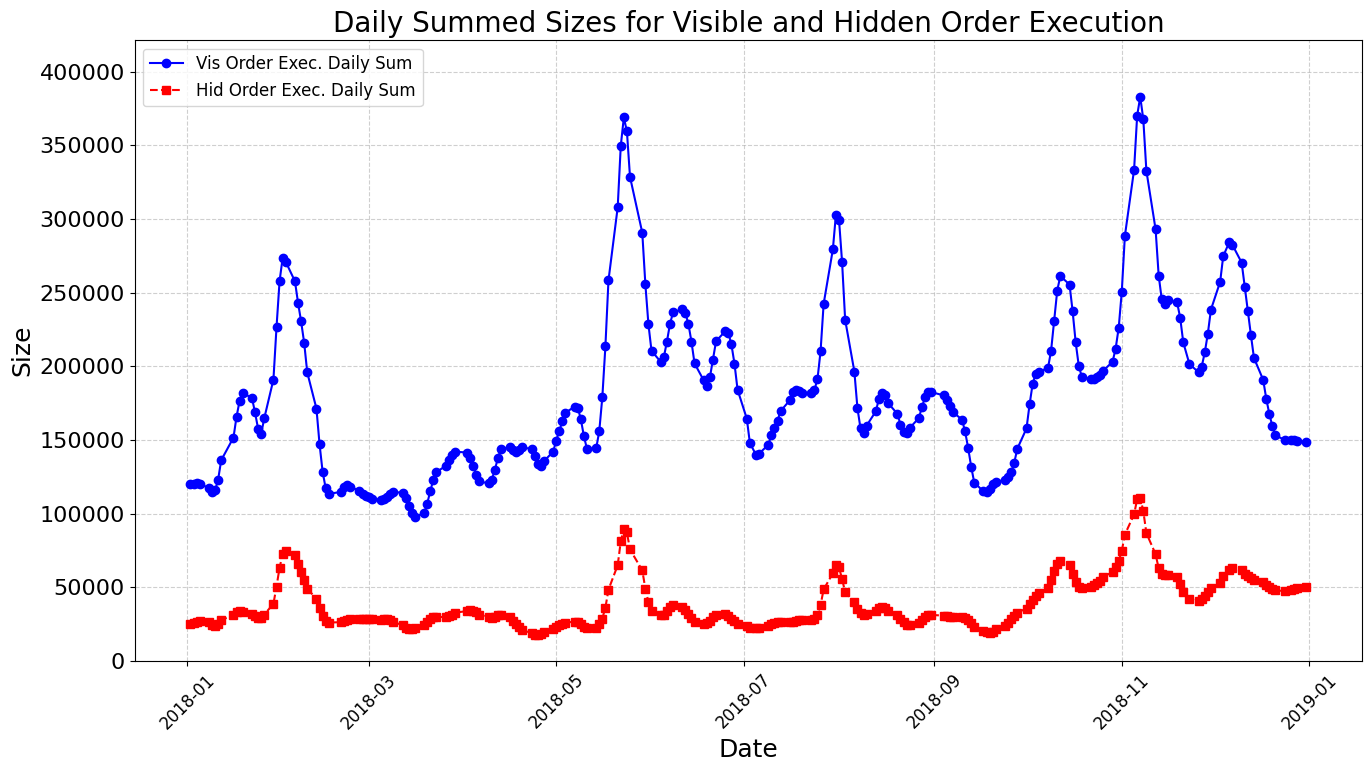

In [9]:
from scipy.ndimage import gaussian_filter1d

# Smoothing the data
smoothed_df_4 = gaussian_filter1d(df_4_daily_sum, sigma=2)
smoothed_df_5 = gaussian_filter1d(df_5_daily_sum, sigma=2)

# Create a figure and axis
plt.figure(figsize=(14, 8))
plt.rcParams.update({'font.size': 16})

# Plot the smoothed daily summed sizes for visible order execution
plt.plot(df_4_daily_sum.index, smoothed_df_4, label='Vis Order Exec. Daily Sum', color='blue', linestyle='-', marker='o')

# Plot the smoothed daily summed sizes for hidden order execution
plt.plot(df_5_daily_sum.index, smoothed_df_5, label='Hid Order Exec. Daily Sum', color='red', linestyle='--', marker='s')

# Set labels and title
plt.xlabel('Date', fontsize=18)
plt.ylabel('Size', fontsize=18)
plt.title('Daily Summed Sizes for Visible and Hidden Order Execution', fontsize=20)

# Rotate the x-ticks by 45 degrees
plt.xticks(rotation=45, fontsize=12)

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.6)

# Add a legend
plt.legend(loc='upper left', fontsize=12)

# Adjust the y-axis limit
plt.ylim(0, max(smoothed_df_4.max(), smoothed_df_5.max()) * 1.1)

plt.tight_layout()
plt.show()


In [10]:
def plot_mean_with_std(df):
    # Group by the 'time' column and calculate the mean and standard deviation for 'size'
    grouped_stats = df.groupby('time')['size'].agg(['mean', 'std'])
    
    # Prepare the plot
    plt.figure(figsize=(12, 6))
    
    # Plot the mean size
    plt.plot(grouped_stats.index.astype('str'), grouped_stats['mean'], label='Mean Size', color='blue')

    # Plot the standard deviation bounds
    plt.fill_between(grouped_stats.index.astype('str'),
                     grouped_stats['mean'] - 1.96 * grouped_stats['std'],
                     grouped_stats['mean'] + 1.96 * grouped_stats['std'],
                     color='blue', alpha=0.2, label='Mean with confidence int.')

    # Formatting the plot
    plt.xlabel('Time')
    plt.ylabel('Size')
    plt.title('Mean Size with Standard Deviation Bounds by Time Bucket')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

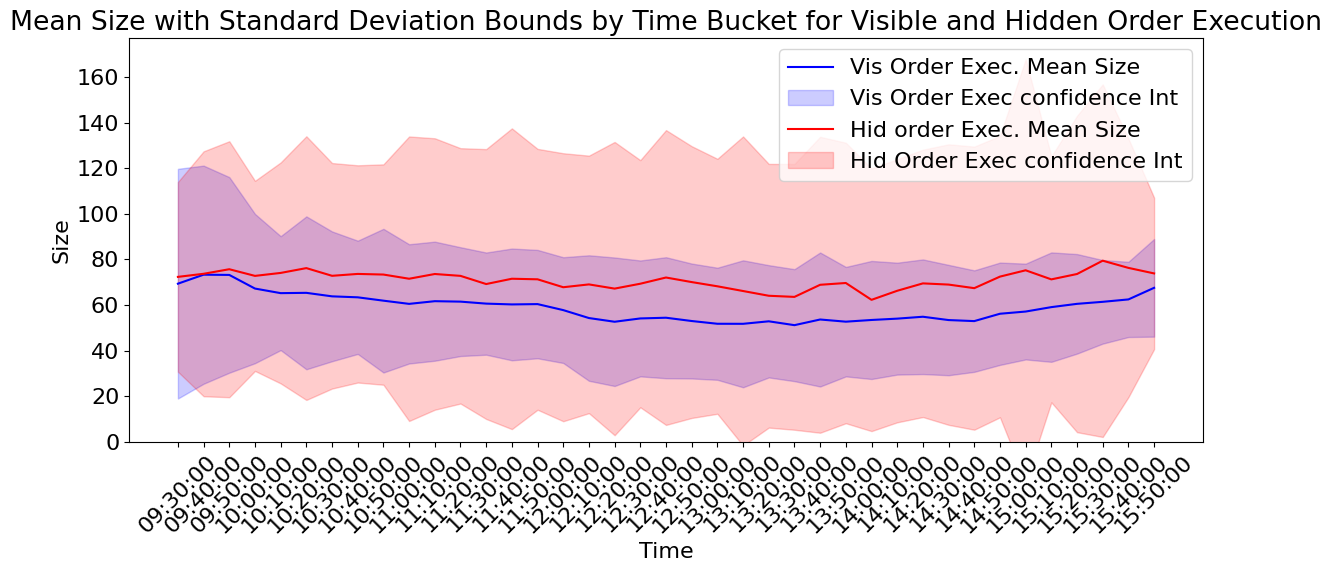

In [11]:
plt.figure(figsize=(12, 6))

df_4_stats = df_mean_std_calc(df_4_resampled)
df_5_stats = df_mean_std_calc(df_5_resampled)

 # Plot the mean size
plt.plot(df_4_stats.index.astype('str'), df_4_stats['mean'], label='Vis Order Exec. Mean Size', color='blue')

# Plot the standard deviation bounds
plt.fill_between(df_4_stats.index.astype('str'),
                    df_4_stats['mean'] - 1.96 * df_4_stats['std'],
                    df_4_stats['mean'] + 1.96 * df_4_stats['std'],
                    color='blue', alpha=0.2, label='Vis Order Exec confidence Int')


plt.plot(df_5_stats.index.astype('str'), df_5_stats['mean'], label='Hid order Exec. Mean Size', color='red')

# Plot the standard deviation bounds
plt.fill_between(df_5_stats.index.astype('str'),
                    df_5_stats['mean'] - 1.96 * df_5_stats['std'],
                    df_5_stats['mean'] + 1.96 * df_5_stats['std'],
                    color='red', alpha=0.2, label='Hid Order Exec confidence Int')

# Formatting the plot
plt.xlabel('Time')
plt.ylabel('Size')
plt.title('Mean Size with Standard Deviation Bounds by Time Bucket for Visible and Hidden Order Execution')
plt.xticks(rotation=45)
plt.legend()
plt.ylim(bottom=0)
# Show the plot
plt.tight_layout()
plt.show()


In [12]:
hid_vis_size_ratio = df_5_resampled_sum['size'] / df_4_resampled_sum['size']
hid_vis_size_ratio = hid_vis_size_ratio.to_frame()
hid_vis_size_ratio['time'] = hid_vis_size_ratio.index.time

hid_vis_size_ratio = df_mean_std_calc(hid_vis_size_ratio, month=False)

<Figure size 1200x600 with 0 Axes>

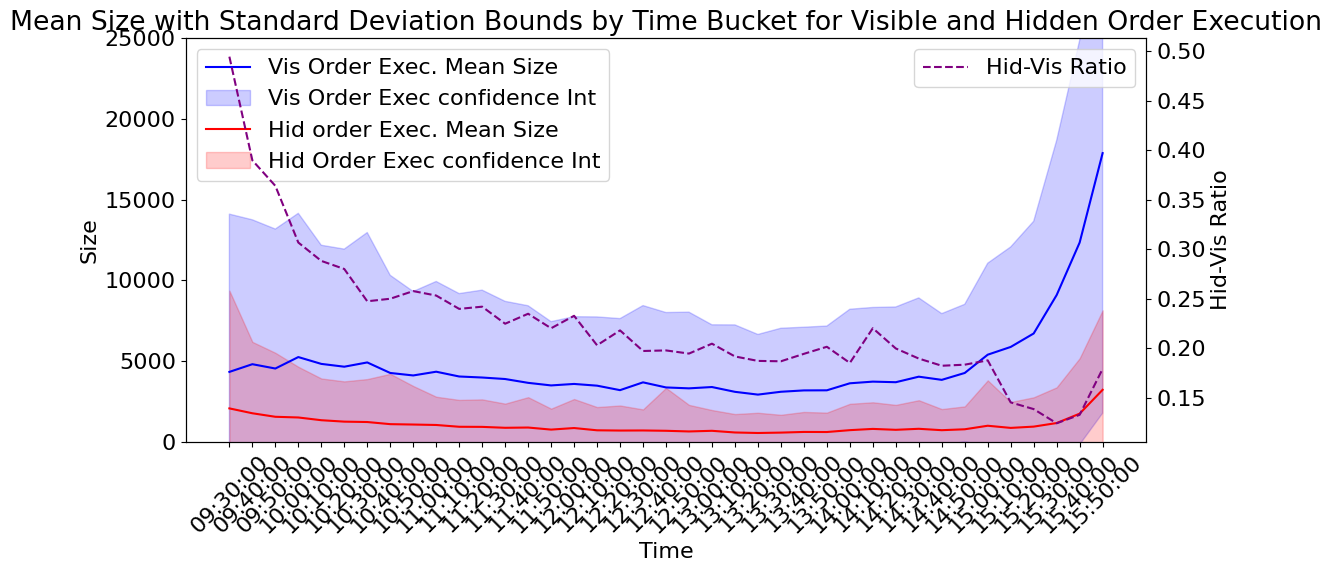

In [13]:

plt.figure(figsize=(12, 6))

# Calculate statistics
df_4_stats = df_mean_std_calc(df_4_resampled_sum)
df_5_stats = df_mean_std_calc(df_5_resampled_sum)

# Create the primary axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot on the primary axis
ax1.plot(df_4_stats.index.astype('str'), df_4_stats['mean'], label='Vis Order Exec. Mean Size', color='blue')
ax1.fill_between(df_4_stats.index.astype('str'),
                 df_4_stats['mean'] - 1.96 * df_4_stats['std'],
                 df_4_stats['mean'] + 1.96 * df_4_stats['std'],
                 color='blue', alpha=0.2, label='Vis Order Exec confidence Int')

ax1.plot(df_5_stats.index.astype('str'), df_5_stats['mean'], label='Hid order Exec. Mean Size', color='red')
ax1.fill_between(df_5_stats.index.astype('str'),
                 df_5_stats['mean'] - 1.96 * df_5_stats['std'],
                 df_5_stats['mean'] + 1.96 * df_5_stats['std'],
                 color='red', alpha=0.2, label='Hid Order Exec confidence Int')

# Set labels for the primary y-axis
ax1.set_xlabel('Time')
ax1.set_ylabel('Size')
ax1.set_title('Mean Size with Standard Deviation Bounds by Time Bucket for Visible and Hidden Order Execution')
ax1.set_ylim([0, 25000])
ax1.legend(loc='upper left')

# Rotate the x-ticks by 45 degrees
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

# Create a secondary y-axis
ax2 = ax1.twinx()

# Plot the ratio on the secondary y-axis
ax2.plot(hid_vis_size_ratio.index.astype('str'), hid_vis_size_ratio['mean'], color='purple', linestyle='dashed',
         label="Hid-Vis Ratio")

# Set labels for the secondary y-axis
ax2.set_ylabel('Hid-Vis Ratio')
ax2.legend(loc='upper right')

# Rotate the x-ticks by 45 degrees for the secondary axis
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

# Formatting the plot
plt.tight_layout()

# Show the plot
plt.show()


In [14]:
df_4_resampled['month'] = df_4_resampled.index.month
df_5_resampled['month'] = df_5_resampled.index.month
df_4_resampled_sum['month'] = df_4_resampled_sum.index.month
df_5_resampled_sum['month'] = df_5_resampled_sum.index.month

In [15]:
df_4_stats = df_mean_std_calc(df_4_resampled, month=True)
df_5_stats = df_mean_std_calc(df_5_resampled, month=True)

df_4_stats_sum = df_mean_std_calc(df_4_resampled_sum, month=True)
df_5_stats_sum = df_mean_std_calc(df_5_resampled_sum, month=True)

In [16]:
month_lst = ['Jan', 'Feb', 'Mar', 'Apr', 'May', "Jun", "Jul", "Aug", "Sep", 'Oct', "Nov", "Dec"]

In [17]:
import matplotlib.cm as cm

In [18]:
def plot_monthly_mean_with_std(df, month_lst=month_lst):
    df.index = df.index.set_levels([df.index.levels[0].astype(str), df.index.levels[1]])

    # Prepare the plot
    plt.figure(figsize=(14, 8))

    # Get a colormap with enough distinct colors for each month
    colors = cm.rainbow(np.linspace(0, 1, len(month_lst)))

    # Loop through each month and plot the mean with standard deviation bounds
    for i, (month, month_name) in enumerate(zip(df.index.levels[1], month_lst)):
        monthly_data = df.xs(month, level='month')
        
        # Plot the mean line with a rainbow color
        plt.plot(monthly_data.index, monthly_data['mean'], label=f'{month_name}', color=colors[i])
        
        # Plot the standard deviation bounds
        plt.fill_between(monthly_data.index,
                         monthly_data['mean'] - monthly_data['std'],
                         monthly_data['mean'] + monthly_data['std'],
                         color=colors[i], alpha=0.2)

    # Formatting the plot
    plt.xlabel('Time', fontsize=20)
    plt.ylabel('Size', fontsize=20)
    
    # Adjust x-ticks to be in buckets of 20 minutes
    xticks = monthly_data.index[::2]  # Assuming the data is currently sampled every 10 minutes
    plt.xticks(xticks, rotation=45, size=15)

    # Move the legend to the right side
    plt.legend(title='Month', fontsize=18, title_fontsize=20, loc='center left', bbox_to_anchor=(1, 0.5))

    plt.ylim(bottom=0)
    
    # Show the plot
    plt.tight_layout()


Text(0.5, 1.0, 'Vis Order Exec Mean Total Size with Standard Deviation by Time Bucket and Month')

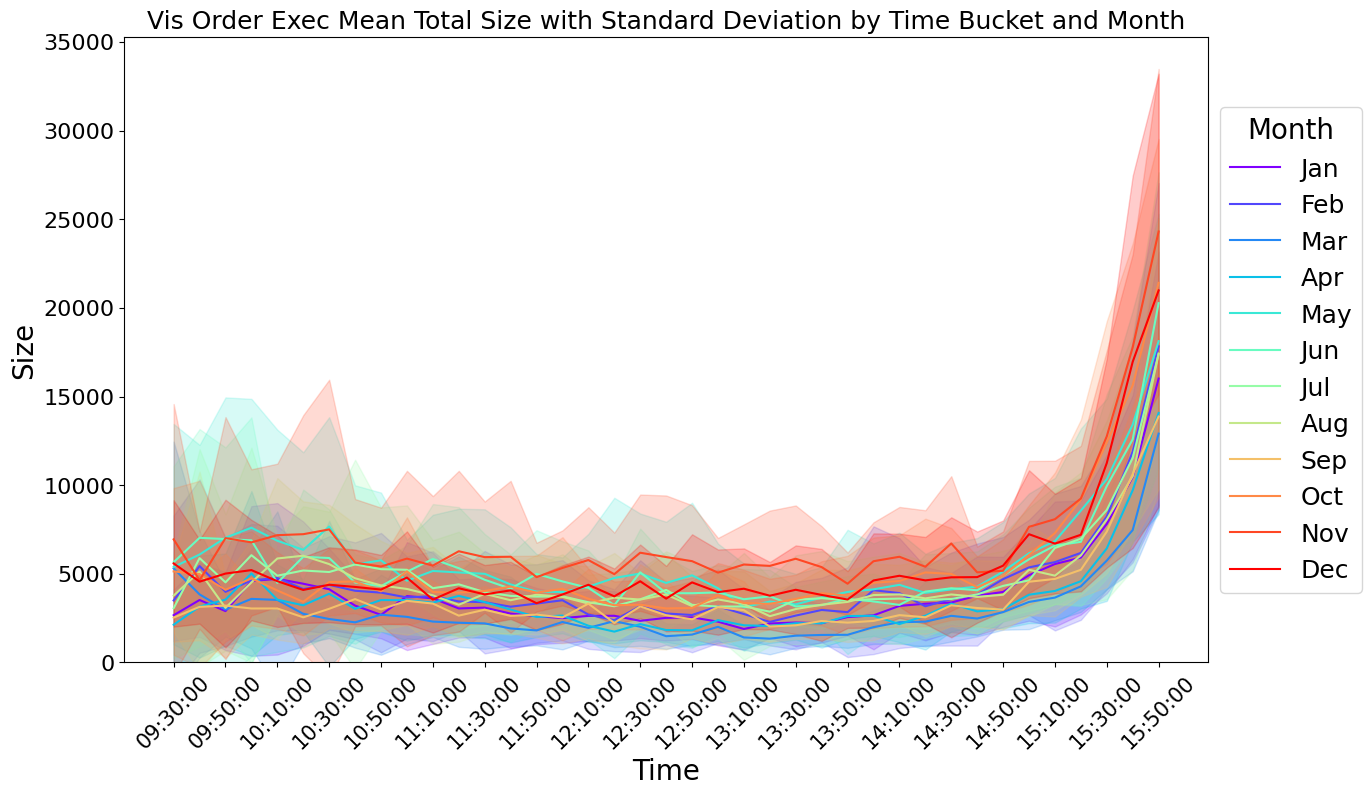

In [19]:
plot_monthly_mean_with_std(df_4_stats_sum)
plt.title('Vis Order Exec Mean Total Size with Standard Deviation by Time Bucket and Month', fontsize=18)


Text(0.5, 1.0, 'Vis Order Exec Mean Size with Standard Deviation by Time Bucket and Month')

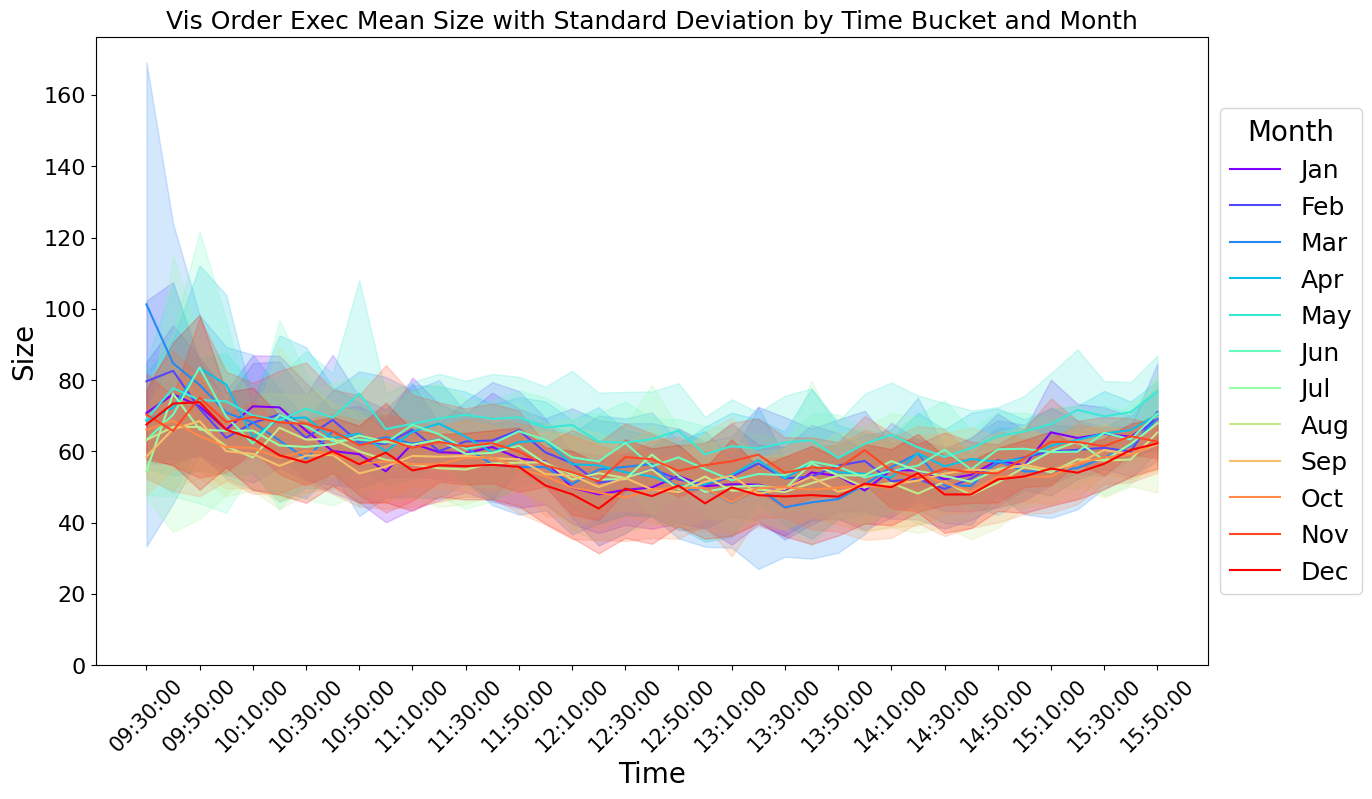

In [20]:
plot_monthly_mean_with_std(df_4_stats)
plt.title('Vis Order Exec Mean Size with Standard Deviation by Time Bucket and Month', fontsize=18)

Text(0.5, 1.0, 'Hid Order Exec Mean Total Size with Standard Deviation by Time Bucket and Month')

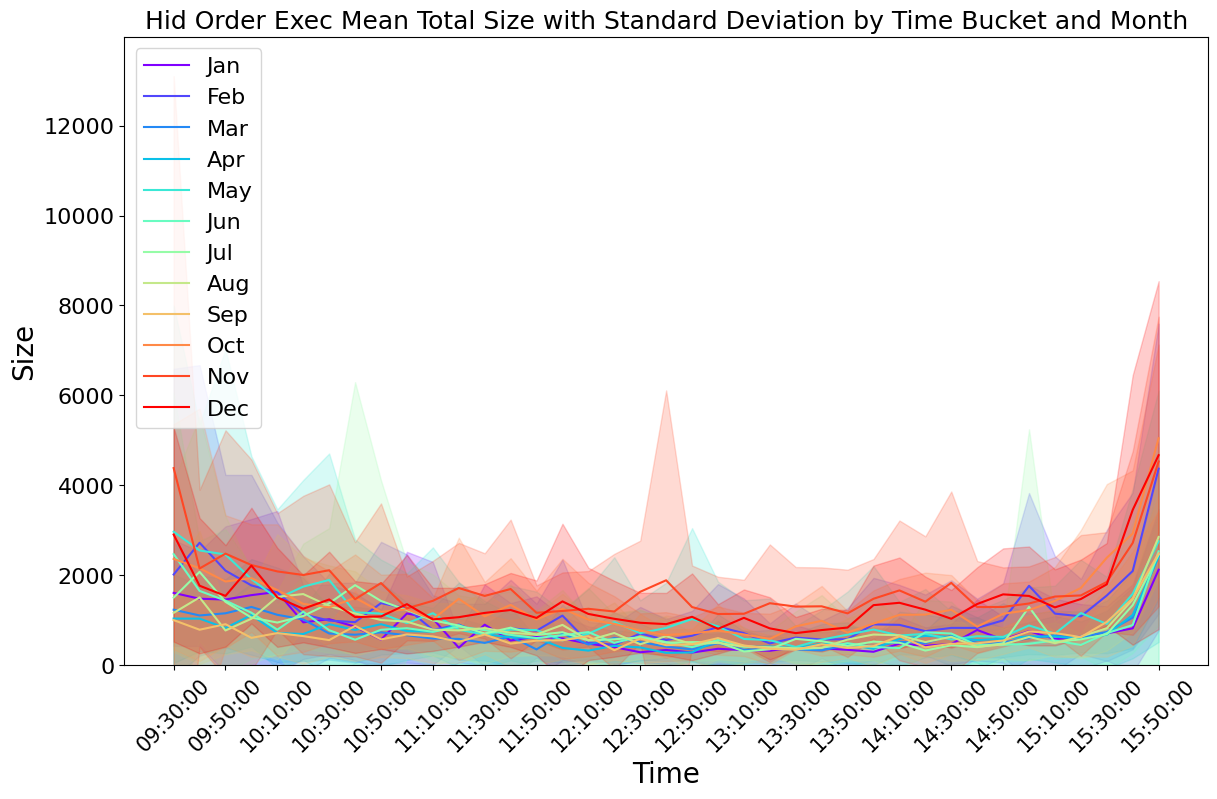

In [21]:
plot_monthly_mean_with_std(df_5_stats_sum)
plt.legend(loc='upper left')
plt.title('Hid Order Exec Mean Total Size with Standard Deviation by Time Bucket and Month', fontsize=18)


Text(0.5, 1.0, 'Hid Order Exec Mean Size with Standard Deviation by Time Bucket and Month')

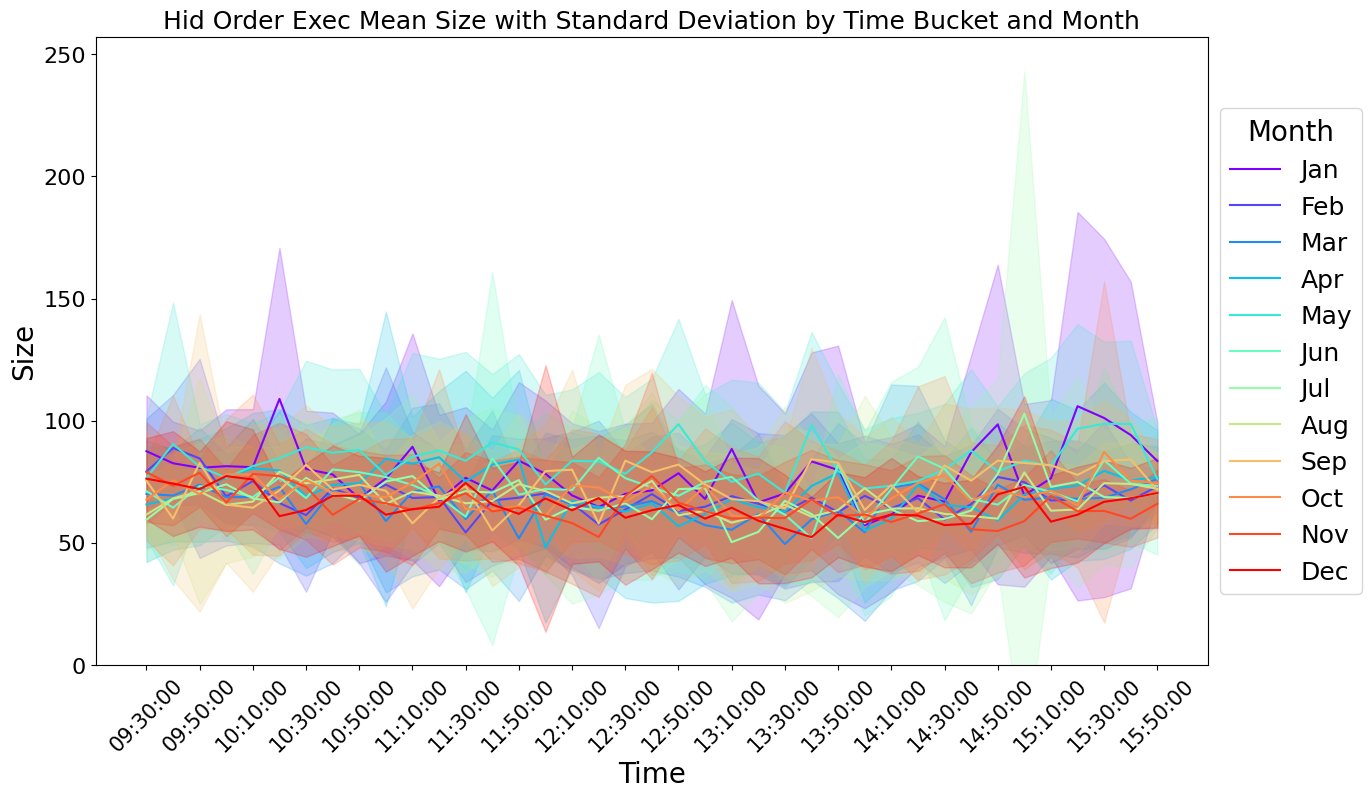

In [22]:
plot_monthly_mean_with_std(df_5_stats)
plt.title('Hid Order Exec Mean Size with Standard Deviation by Time Bucket and Month', fontsize=18)

- Last 30 minutes bucket is very volatile
- Generally, behaviour of hidden and visible order executions are similar by month (hence we do not really need to adjust for seasonal effects)
- By first and second image, on average, the size of hidden order executions are larger than the size of visible order executions. However, the variance is also much greater than hidden order execution sizes.

## Size Analysis

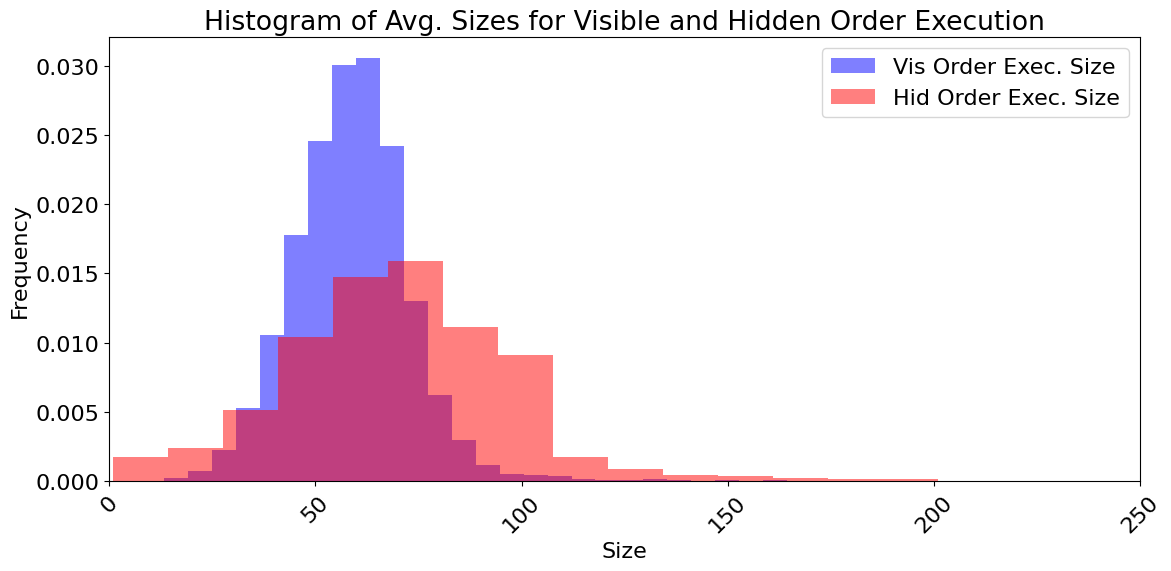

In [23]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the histograms with transparency
ax.hist(df_4_resampled['size'], bins=50, alpha=0.5, color='blue', label='Vis Order Exec. Size', density=True)
ax.hist(df_5_resampled['size'], bins=50, alpha=0.5, color='red', label='Hid Order Exec. Size', density=True)

# Set labels and title
ax.set_xlabel('Size')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Avg. Sizes for Visible and Hidden Order Execution')

# Add a legend
ax.legend(loc='upper right')
ax.set_xlim(0, 250)


# Rotate the x-ticks by 45 degrees
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
# Adjust layout
plt.tight_layout()
# Show the plot
plt.show()


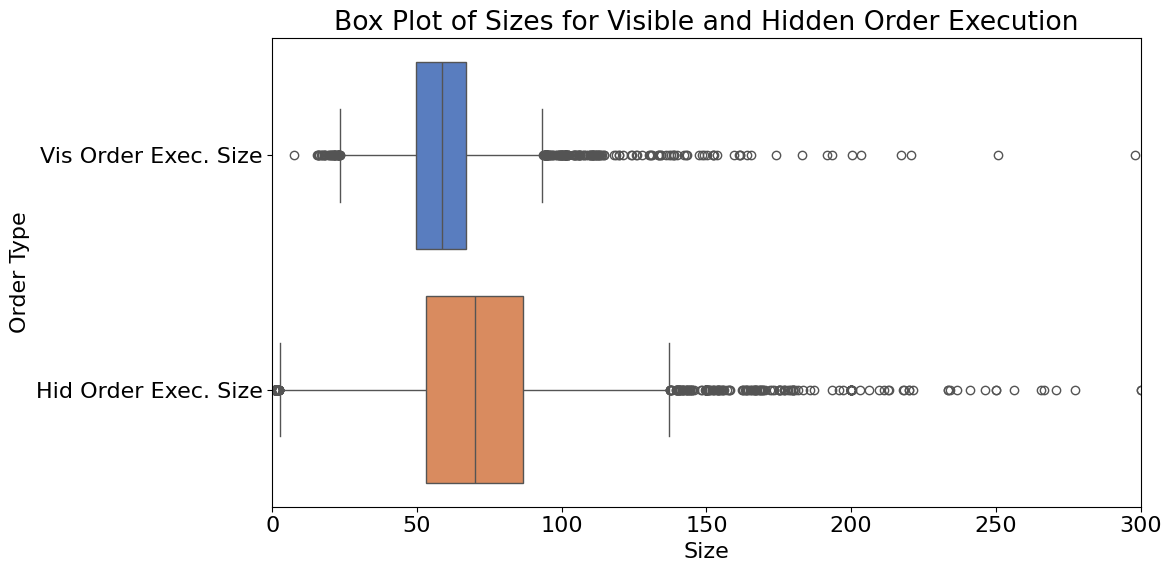

In [24]:
data = {
    'Size': list(df_4_resampled['size']) + list(df_5_resampled['size']),
    'Type': ['Vis Order Exec. Size'] * len(df_4_resampled['size']) + ['Hid Order Exec. Size'] * len(df_5_resampled['size'])
}

combined_df = pd.DataFrame(data)

# Create the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Size', y='Type', data=combined_df, palette='muted')

# Set the x-axis limit
plt.xlim(0, 300) 

# Set labels and title
plt.xlabel('Size')
plt.ylabel('Order Type')
plt.title('Box Plot of Sizes for Visible and Hidden Order Execution')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


## Analysis for Iceberg Orders

In [25]:
df_4_vis_ib, df_5_ib, df_4_ib = mean_analysis("RL", iceberg=True, calc_type='agg')

Processed files: RL_2018-01-02_34200000_57600000_orderbook_10.csv RL_2018-01-02_34200000_57600000_message_10.csv
Processed files: RL_2018-01-03_34200000_57600000_orderbook_10.csv RL_2018-01-03_34200000_57600000_message_10.csv
Processed files: RL_2018-01-04_34200000_57600000_orderbook_10.csv RL_2018-01-04_34200000_57600000_message_10.csv
Processed files: RL_2018-01-05_34200000_57600000_orderbook_10.csv RL_2018-01-05_34200000_57600000_message_10.csv
Processed files: RL_2018-01-08_34200000_57600000_orderbook_10.csv RL_2018-01-08_34200000_57600000_message_10.csv
Processed files: RL_2018-01-09_34200000_57600000_orderbook_10.csv RL_2018-01-09_34200000_57600000_message_10.csv
Processed files: RL_2018-01-10_34200000_57600000_orderbook_10.csv RL_2018-01-10_34200000_57600000_message_10.csv
Processed files: RL_2018-01-11_34200000_57600000_orderbook_10.csv RL_2018-01-11_34200000_57600000_message_10.csv
Processed files: RL_2018-01-12_34200000_57600000_orderbook_10.csv RL_2018-01-12_34200000_5760000

Processed files: RL_2018-02-05_34200000_57600000_orderbook_10.csv RL_2018-02-05_34200000_57600000_message_10.csv
Processed files: RL_2018-02-06_34200000_57600000_orderbook_10.csv RL_2018-02-06_34200000_57600000_message_10.csv
Processed files: RL_2018-02-07_34200000_57600000_orderbook_10.csv RL_2018-02-07_34200000_57600000_message_10.csv
Processed files: RL_2018-02-08_34200000_57600000_orderbook_10.csv RL_2018-02-08_34200000_57600000_message_10.csv
Processed files: RL_2018-02-09_34200000_57600000_orderbook_10.csv RL_2018-02-09_34200000_57600000_message_10.csv
Processed files: RL_2018-02-12_34200000_57600000_orderbook_10.csv RL_2018-02-12_34200000_57600000_message_10.csv
Processed files: RL_2018-02-13_34200000_57600000_orderbook_10.csv RL_2018-02-13_34200000_57600000_message_10.csv
Processed files: RL_2018-02-14_34200000_57600000_orderbook_10.csv RL_2018-02-14_34200000_57600000_message_10.csv
Processed files: RL_2018-02-15_34200000_57600000_orderbook_10.csv RL_2018-02-15_34200000_5760000

In [26]:
df_4_vis_ib = process_df(df_4_vis_ib)
df_5_ib = process_df(df_5_ib)
df_4_ib = process_df(df_4_ib)

In [27]:
hid_vis_size_ratio_ib = df_5_ib['size'] / df_4_vis_ib['size']
hid_vis_size_ratio_ib = hid_vis_size_ratio_ib.to_frame()
hid_vis_size_ratio_ib['time'] = hid_vis_size_ratio_ib.index.time
hid_vis_size_ratio_ib = df_mean_std_calc(hid_vis_size_ratio_ib, month=False)



ib_vis_size_ratio_ib = df_4_ib['size'] / df_4_vis_ib['size']
ib_vis_size_ratio_ib = ib_vis_size_ratio_ib.to_frame()
ib_vis_size_ratio_ib['time'] = ib_vis_size_ratio_ib.index.time
ib_vis_size_ratio_ib = df_mean_std_calc(ib_vis_size_ratio_ib, month=False)

<Figure size 1200x600 with 0 Axes>

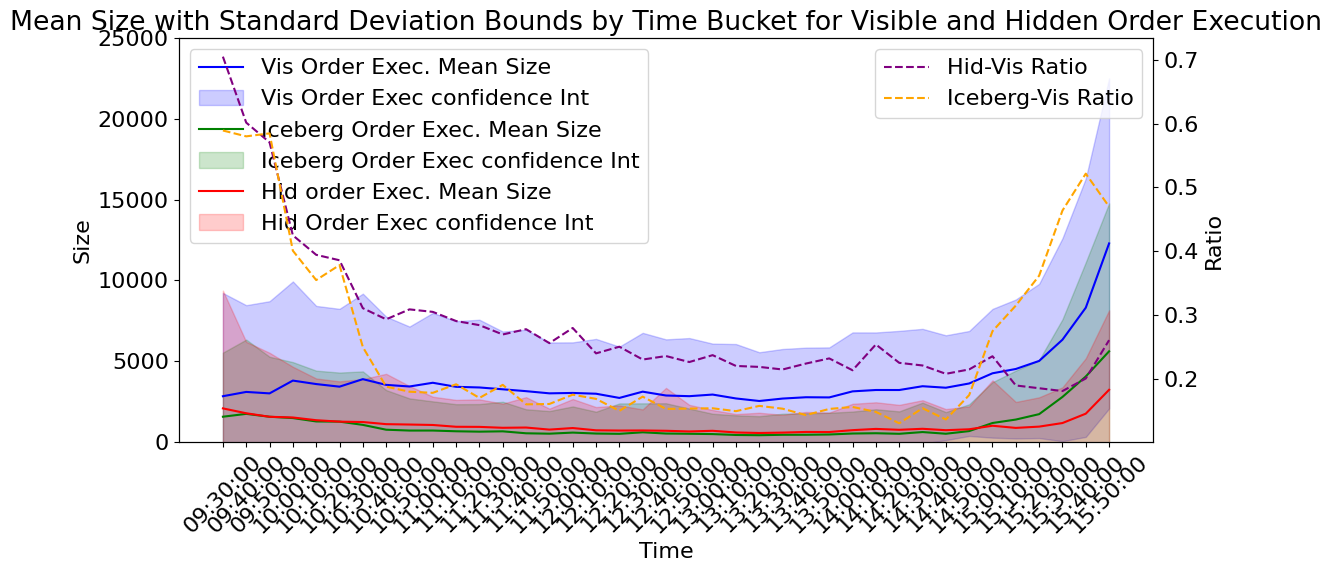

In [28]:
plt.figure(figsize=(12, 6))

# Calculate statistics
df_4_stats = df_mean_std_calc(df_4_vis_ib)
df_4_iceberg_stats = df_mean_std_calc(df_4_ib)
df_5_stats = df_mean_std_calc(df_5_ib)

# Create the primary axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot on the primary axis
ax1.plot(df_4_stats.index.astype('str'), df_4_stats['mean'], label='Vis Order Exec. Mean Size', color='blue')
ax1.fill_between(df_4_stats.index.astype('str'),
                 df_4_stats['mean'] - 1.96 * df_4_stats['std'],
                 df_4_stats['mean'] + 1.96 * df_4_stats['std'],
                 color='blue', alpha=0.2, label='Vis Order Exec confidence Int')

# Plot on the primary axis
ax1.plot(df_4_iceberg_stats.index.astype('str'), df_4_iceberg_stats['mean'], label='Iceberg Order Exec. Mean Size', color='green')
ax1.fill_between(df_4_iceberg_stats.index.astype('str'),
                 df_4_iceberg_stats['mean'] - 1.96 * df_4_iceberg_stats['std'],
                 df_4_iceberg_stats['mean'] + 1.96 * df_4_iceberg_stats['std'],
                 color='green', alpha=0.2, label='Iceberg Order Exec confidence Int')

ax1.plot(df_5_stats.index.astype('str'), df_5_stats['mean'], label='Hid order Exec. Mean Size', color='red')
ax1.fill_between(df_5_stats.index.astype('str'),
                 df_5_stats['mean'] - 1.96 * df_5_stats['std'],
                 df_5_stats['mean'] + 1.96 * df_5_stats['std'],
                 color='red', alpha=0.2, label='Hid Order Exec confidence Int')

# Set labels for the primary y-axis
ax1.set_xlabel('Time')
ax1.set_ylabel('Size')
ax1.set_title('Mean Size with Standard Deviation Bounds by Time Bucket for Visible and Hidden Order Execution')
ax1.set_ylim([0, 25000])
ax1.legend(loc='upper left')

# Rotate the x-ticks by 45 degrees
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

# Create a secondary y-axis
ax2 = ax1.twinx()

# Plot the ratio on the secondary y-axis
ax2.plot(hid_vis_size_ratio_ib.index.astype('str'), hid_vis_size_ratio_ib['mean'], color='purple', linestyle='dashed',
         label="Hid-Vis Ratio")

# Plot the ratio on the secondary y-axis
ax2.plot(ib_vis_size_ratio_ib.index.astype('str'), ib_vis_size_ratio_ib['mean'], color='orange', linestyle='dashed',
         label="Iceberg-Vis Ratio")

# Set labels for the secondary y-axis
ax2.set_ylabel('Ratio')
ax2.legend(loc='upper right')

# Rotate the x-ticks by 45 degrees for the secondary axis as well
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

# Formatting the plot
plt.tight_layout()

# Show the plot
plt.show()


In [29]:
df_4_vis_ib_mean, df_5_ib_mean, df_4_ib_mean = mean_analysis("RL", iceberg=True, calc_type='mean')

df_4_vis_ib_mean = process_df(df_4_vis_ib_mean)
df_5_ib_mean = process_df(df_5_ib_mean)
df_4_ib_mean = process_df(df_4_ib_mean)



Processed files: RL_2018-01-02_34200000_57600000_orderbook_10.csv RL_2018-01-02_34200000_57600000_message_10.csv
Processed files: RL_2018-01-03_34200000_57600000_orderbook_10.csv RL_2018-01-03_34200000_57600000_message_10.csv
Processed files: RL_2018-01-04_34200000_57600000_orderbook_10.csv RL_2018-01-04_34200000_57600000_message_10.csv


Processed files: RL_2018-01-05_34200000_57600000_orderbook_10.csv RL_2018-01-05_34200000_57600000_message_10.csv
Processed files: RL_2018-01-08_34200000_57600000_orderbook_10.csv RL_2018-01-08_34200000_57600000_message_10.csv
Processed files: RL_2018-01-09_34200000_57600000_orderbook_10.csv RL_2018-01-09_34200000_57600000_message_10.csv
Processed files: RL_2018-01-10_34200000_57600000_orderbook_10.csv RL_2018-01-10_34200000_57600000_message_10.csv
Processed files: RL_2018-01-11_34200000_57600000_orderbook_10.csv RL_2018-01-11_34200000_57600000_message_10.csv
Processed files: RL_2018-01-12_34200000_57600000_orderbook_10.csv RL_2018-01-12_34200000_57600000_message_10.csv
Processed files: RL_2018-01-16_34200000_57600000_orderbook_10.csv RL_2018-01-16_34200000_57600000_message_10.csv
Processed files: RL_2018-01-17_34200000_57600000_orderbook_10.csv RL_2018-01-17_34200000_57600000_message_10.csv
Processed files: RL_2018-01-18_34200000_57600000_orderbook_10.csv RL_2018-01-18_34200000_5760000

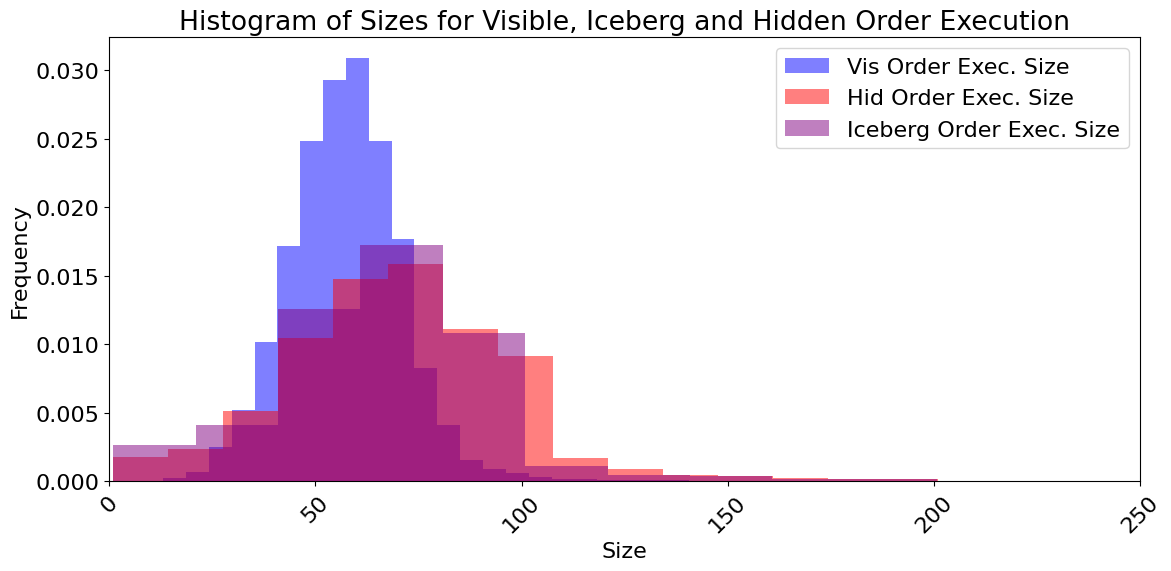

In [30]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the histograms with transparency
ax.hist(df_4_vis_ib_mean['size'], bins=50, alpha=0.5, color='blue', label='Vis Order Exec. Size', density=True)
ax.hist(df_5_ib_mean['size'], bins=50, alpha=0.5, color='red', label='Hid Order Exec. Size', density=True)
ax.hist(df_4_ib_mean['size'], bins=50, alpha=0.5, color='purple', label='Iceberg Order Exec. Size', density=True)


# Set labels and title
ax.set_xlabel('Size')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Sizes for Visible, Iceberg and Hidden Order Execution')

# Add a legend
ax.legend(loc='upper right')
ax.set_xlim(0, 250)


# Rotate the x-ticks by 45 degrees
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
# Adjust layout
plt.tight_layout()
# Show the plot
plt.show()

In [31]:
df_4_ib_mean['size']

datetime
2018-01-02 09:30:00    26.000000
2018-01-02 09:40:00    64.636364
2018-01-02 09:50:00    75.000000
2018-01-02 10:00:00    64.090909
2018-01-02 10:10:00    86.043478
                         ...    
2018-12-31 15:10:00    75.625000
2018-12-31 15:20:00    87.500000
2018-12-31 15:30:00    90.900000
2018-12-31 15:40:00    50.333333
2018-12-31 15:50:00    58.454545
Name: size, Length: 9730, dtype: float64

Text(0.5, 1.0, 'Iceberg Order Exec Mean Size with Standard Deviation by Time Bucket and Month')

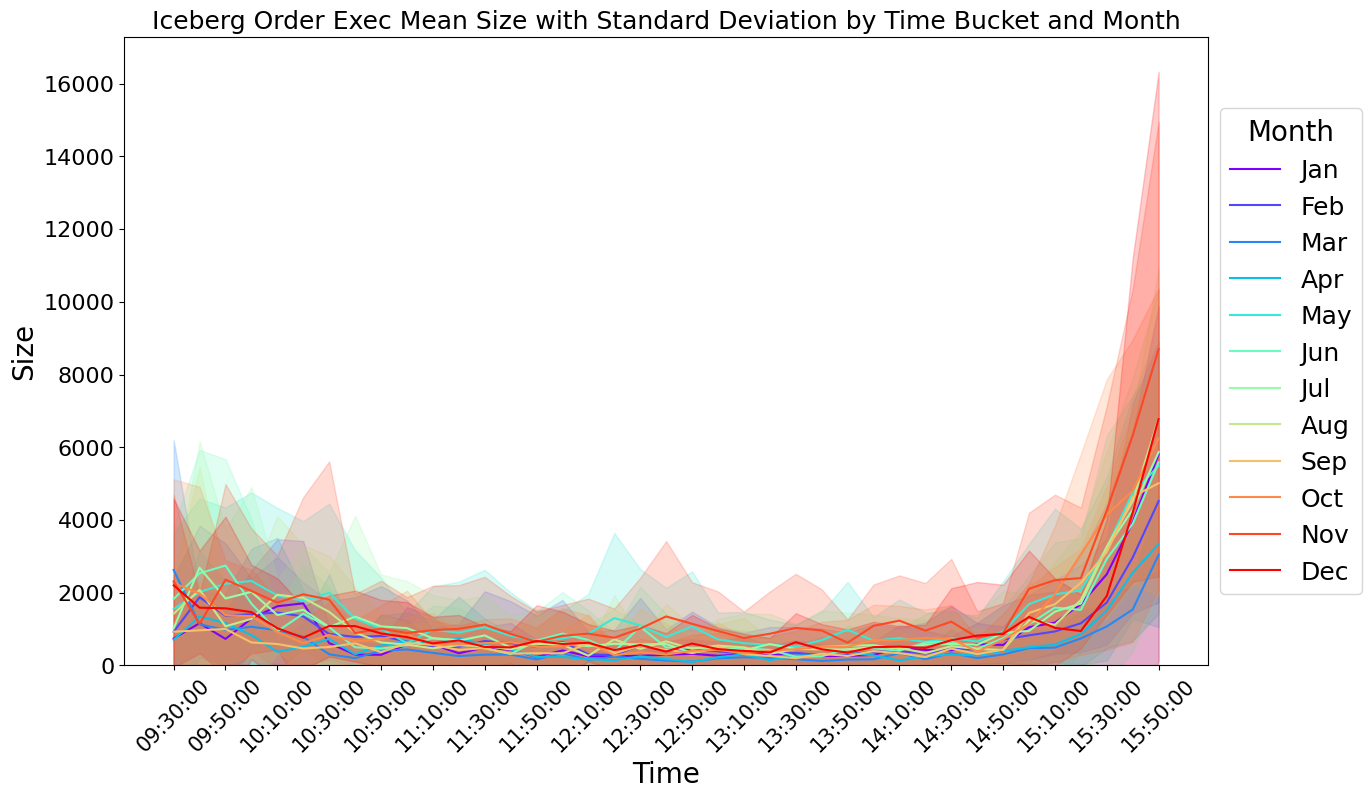

In [32]:
df_iceberg_stats_sum = df_mean_std_calc(df_4_ib, month=True)

plot_monthly_mean_with_std(df_iceberg_stats_sum)
plt.title('Iceberg Order Exec Mean Size with Standard Deviation by Time Bucket and Month', fontsize=18)

In [33]:
df_4_daily_sum

date
2018-01-02    128041
2018-01-03    106737
2018-01-04    126799
2018-01-05    105423
2018-01-08    158976
               ...  
2018-12-24     96428
2018-12-26    155099
2018-12-27    183967
2018-12-28    160437
2018-12-31    124601
Name: size, Length: 251, dtype: int64

In [34]:

df_vis_ib_daily = df_4_vis_ib.groupby('date')['size'].sum()
df_5_ib_daily = df_5_ib.groupby('date')['size'].sum()
df_ib_daily = df_4_ib.groupby('date')['size'].sum()

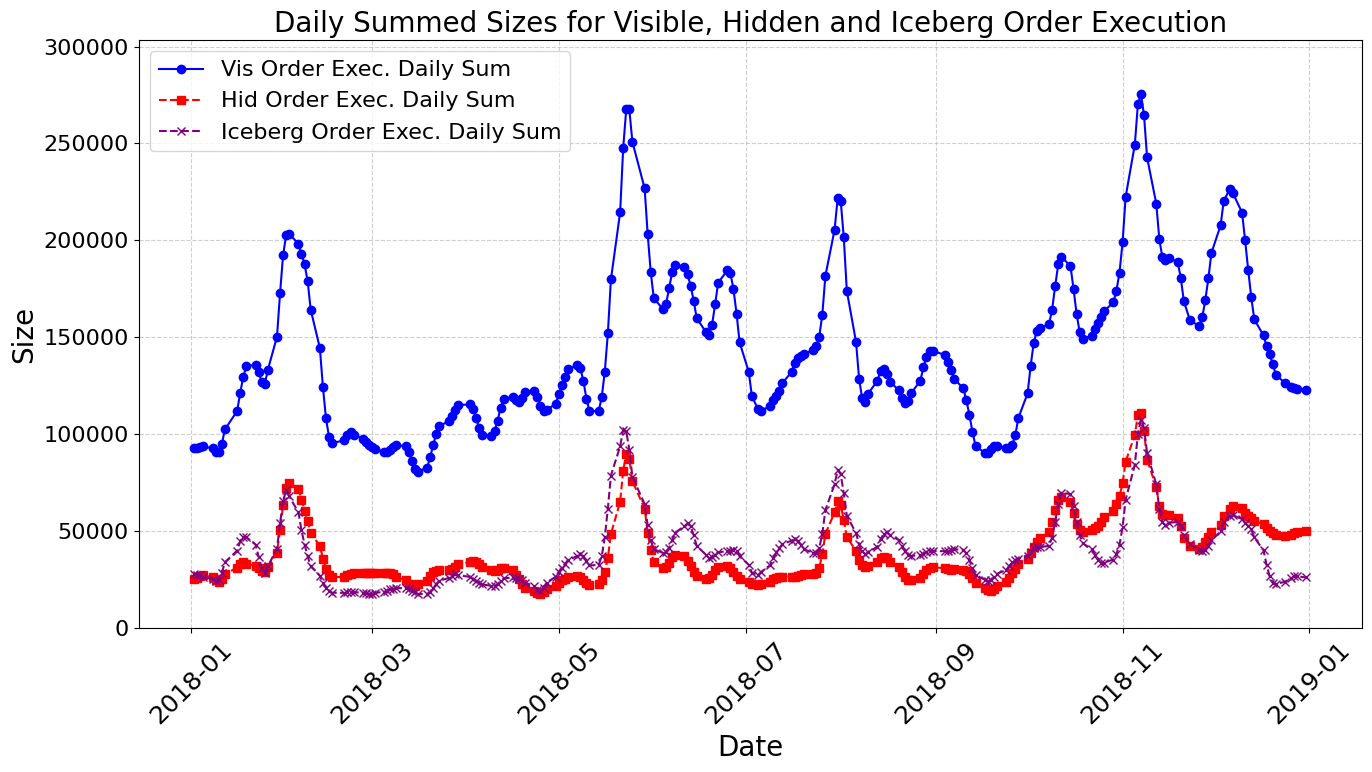

In [35]:
# Smoothing the data
smoothed_df_4 = gaussian_filter1d(df_vis_ib_daily, sigma=2)
smoothed_df_5 = gaussian_filter1d(df_5_ib_daily, sigma=2)
smoothed_df_ib = gaussian_filter1d(df_ib_daily, sigma=2)

# Create a figure and axis
plt.figure(figsize=(14, 8))

# Plot the smoothed daily summed sizes for VoEs
plt.plot(df_vis_ib_daily.index, smoothed_df_4, label='Vis Order Exec. Daily Sum', color='blue', linestyle='-', marker='o')

# Plot the smoothed daily summed sizes for HoEs
plt.plot(df_5_ib_daily.index, smoothed_df_5, label='Hid Order Exec. Daily Sum', color='red', linestyle='--', marker='s')

# Plot the smoothed daily summed sizes for IoEs
plt.plot(df_ib_daily.index, smoothed_df_ib, label='Iceberg Order Exec. Daily Sum', color='purple', linestyle='--', marker='x')


# Set labels and title
plt.xlabel('Date', fontsize=20)
plt.ylabel('Size', fontsize=20)
plt.title('Daily Summed Sizes for Visible, Hidden and Iceberg Order Execution', fontsize=20)

# Rotate the x-ticks by 45 degrees
plt.xticks(rotation=45, fontsize=18)

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.6)

plt.legend(loc='upper left', fontsize=16)

plt.ylim(0, max(smoothed_df_4.max(), smoothed_df_5.max()) * 1.1)
plt.tight_layout()

# Show the plot
plt.show()


In [36]:
df_4_stats_month = df_mean_std_calc(df_4_vis_ib, month=True)
df_4_iceberg_stats_month = df_mean_std_calc(df_4_ib, month=True)
df_5_stats_month = df_mean_std_calc(df_5_ib, month=True)

Text(0.5, 1.0, 'HoE Size by Time Bucket and Month')

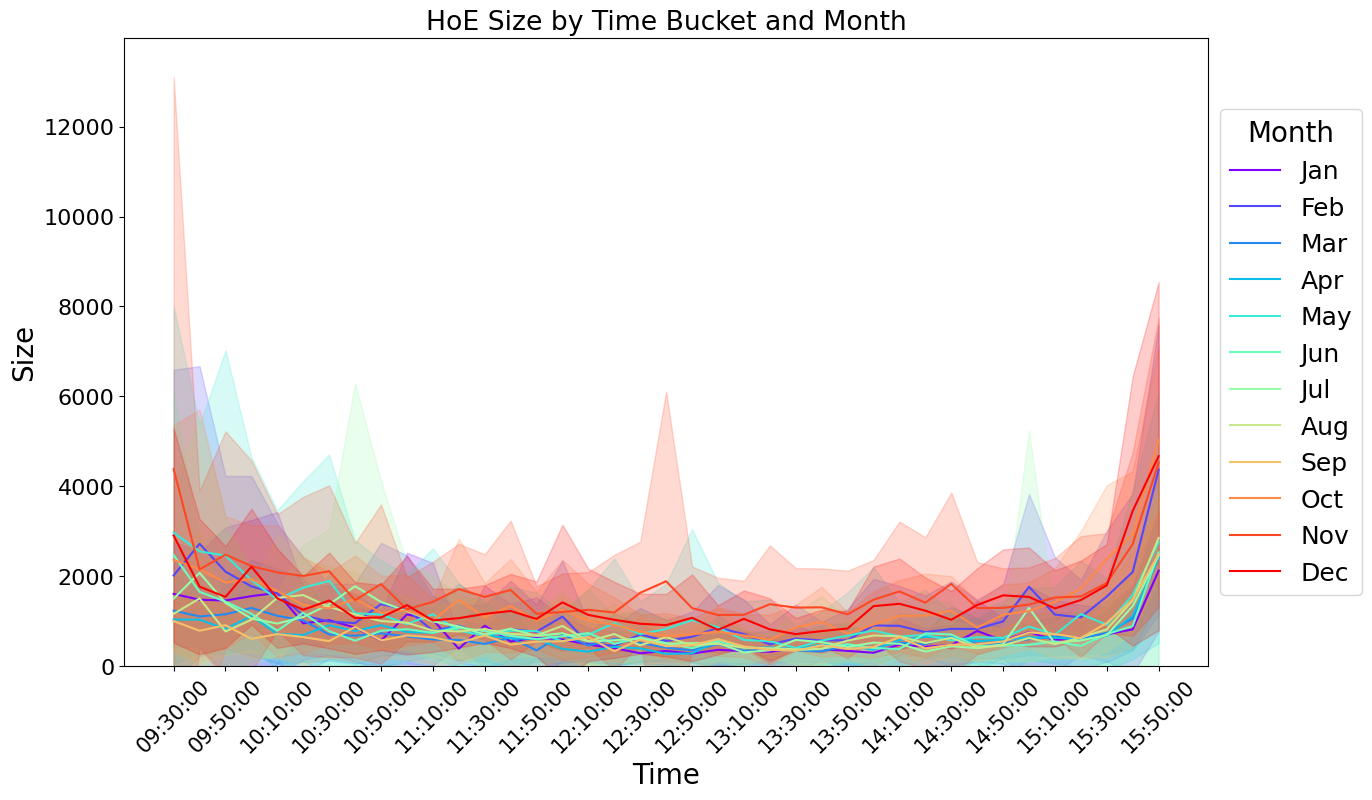

In [37]:
plot_monthly_mean_with_std(df_5_stats_month)
plt.title('HoE Size by Time Bucket and Month')